# Calibration of simulated Au nanoparticles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
from py4DSTEM.visualize import show

In [2]:
filepath_calibation_data = "/media/AuxDriveB/Data/4DSTEM_SampleData/ColinOphus_CalibrationSimulations_StrainedAuNanoplatelet_20191112/data/calibration_data.h5"

## Load data

In [3]:
py4DSTEM.read(filepath_calibation_data)

py4DSTEM file version 0.6.0
Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DataCube          (100, 84, 250, 250)     bullseye_probe_data                                   
  1       DataCube          (100, 84, 250, 250)     bullseye_probe_polyAu                                 
  2       DataCube          (100, 84, 250, 250)     circular_probe_data                                   
  3       DataCube          (100, 84, 250, 250)     circular_probe_polyAu                                 
  4       DiffractionSlice  (250, 250, 20)          bullseye_probe_template                               
  5       DiffractionSlice  (250, 250, 20)          circular_probe_template                               
  6       DiffractionSlice  (512, 512)              defocused_probe                                       


In [4]:
datacube = py4DSTEM.read(
    filepath_calibation_data,
    data_id = "circular_probe_polyAu"
)

In [5]:
datacube.data.shape

(100, 84, 250, 250)

In [6]:
datacube.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
)

## Max diffraction patterns

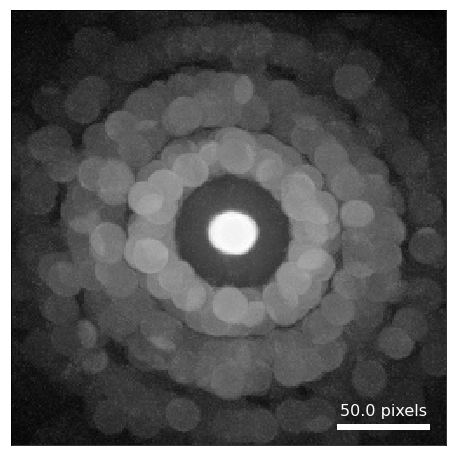

In [7]:
dp_max = datacube.get_dp_max()

show(dp_max, scaling='log')

## Virtual images

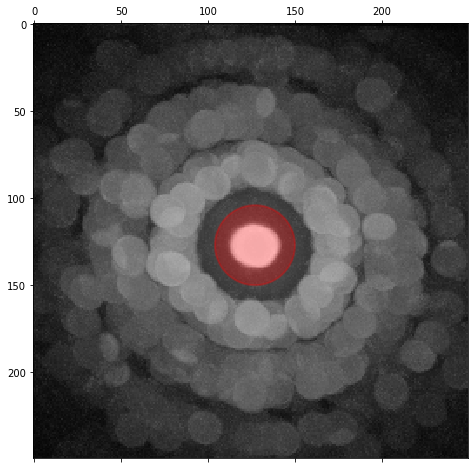

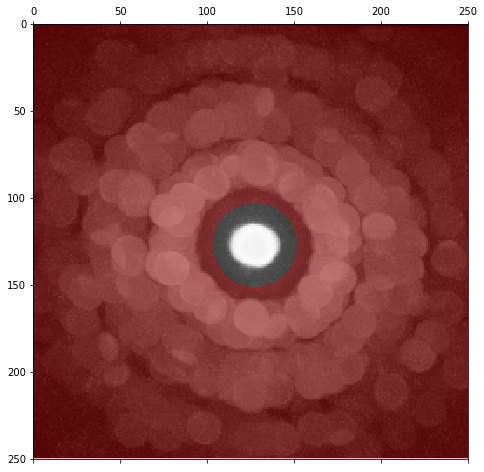

In [8]:
# position detectors

center = (127,127)

radius_BF = 23
radii_ADF = 25,200

# position detectors
py4DSTEM.visualize.show_circles(
    dp_max.data,
    center,
    radius_BF,
    scaling='log'
)
f,a = py4DSTEM.visualize.show_annuli(
    dp_max.data,
    center,
    radii_ADF,
    scaling='log',
    returnfig=True
)
a.set_xlim(0,datacube.Q_Nx)
a.set_ylim(0,datacube.Q_Ny)
a.invert_yaxis()
f.show()

100%|████████████████████████████████████████████████████████████████████████| 8400/8400 [00:00<00:00, 16328.67it/s]


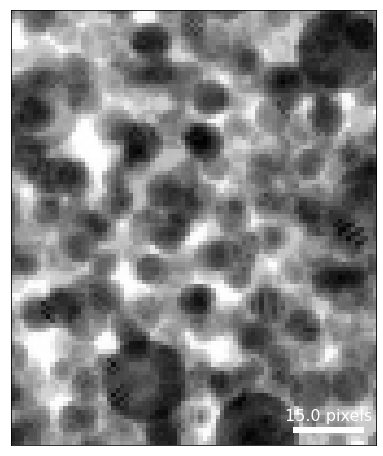

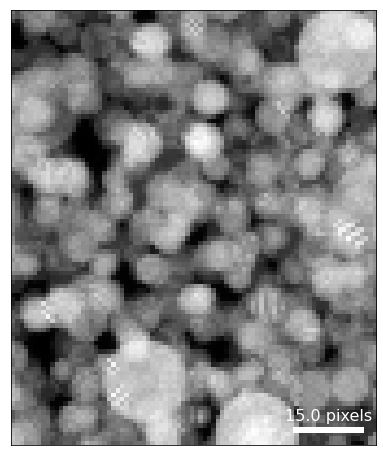

In [9]:
# get virtual images
bf = datacube.get_virtual_image(
    mode = 'circular',
    geometry = (center,radius_BF),
    name = 'bf'
)
adf = datacube.get_virtual_image(
    mode = 'annular',
    geometry = (center,radii_ADF),
    name = 'adf'
)

show(bf)
show(adf)

## Get the probe template

In [10]:
# Load a 3D stack of vacuum probe images

circular_probe_3Dstack = py4DSTEM.read(
    filepath_calibation_data,
    data_id = "circular_probe_template"
)

In [11]:
# Generate a probe by averaging the images

probe = py4DSTEM.process.probe.get_vacuum_probe(
    circular_probe_3Dstack.data
)
probe = py4DSTEM.io.Probe(probe)

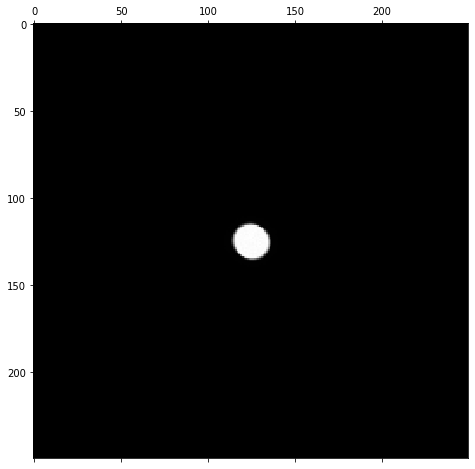

In [12]:
show(probe.probe)

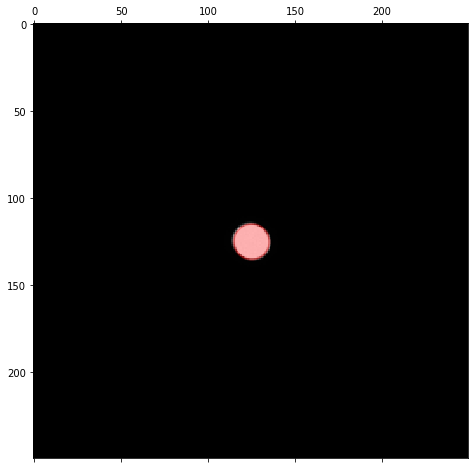

In [13]:
alpha_pix,qx0,qy0 = py4DSTEM.process.calibration.get_probe_size(probe.probe)

py4DSTEM.visualize.show_circles(probe.probe,(qx0,qy0),alpha_pix)

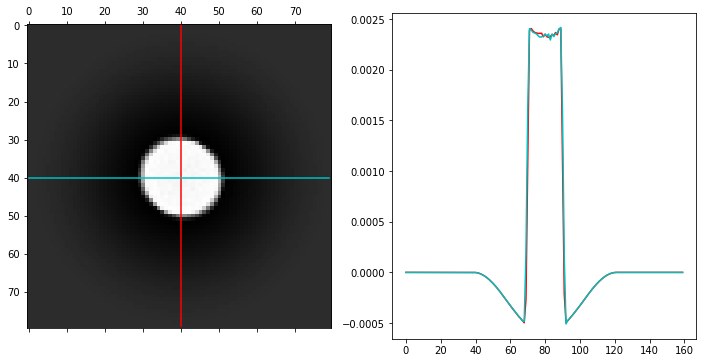

In [14]:
probe_kernel = probe.get_kernel(
    mode = 'sigmoid',
    radii = (0, 4*alpha_pix)
)

py4DSTEM.visualize.show_kernel(probe_kernel, R=40,L=80,W=1)

## Disk detection

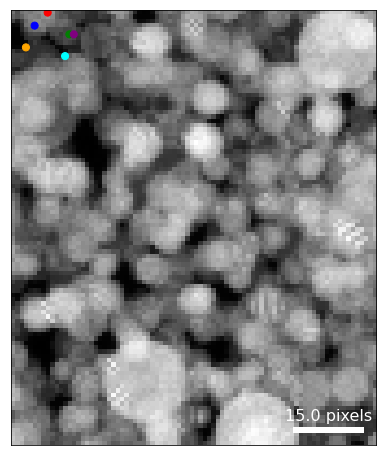

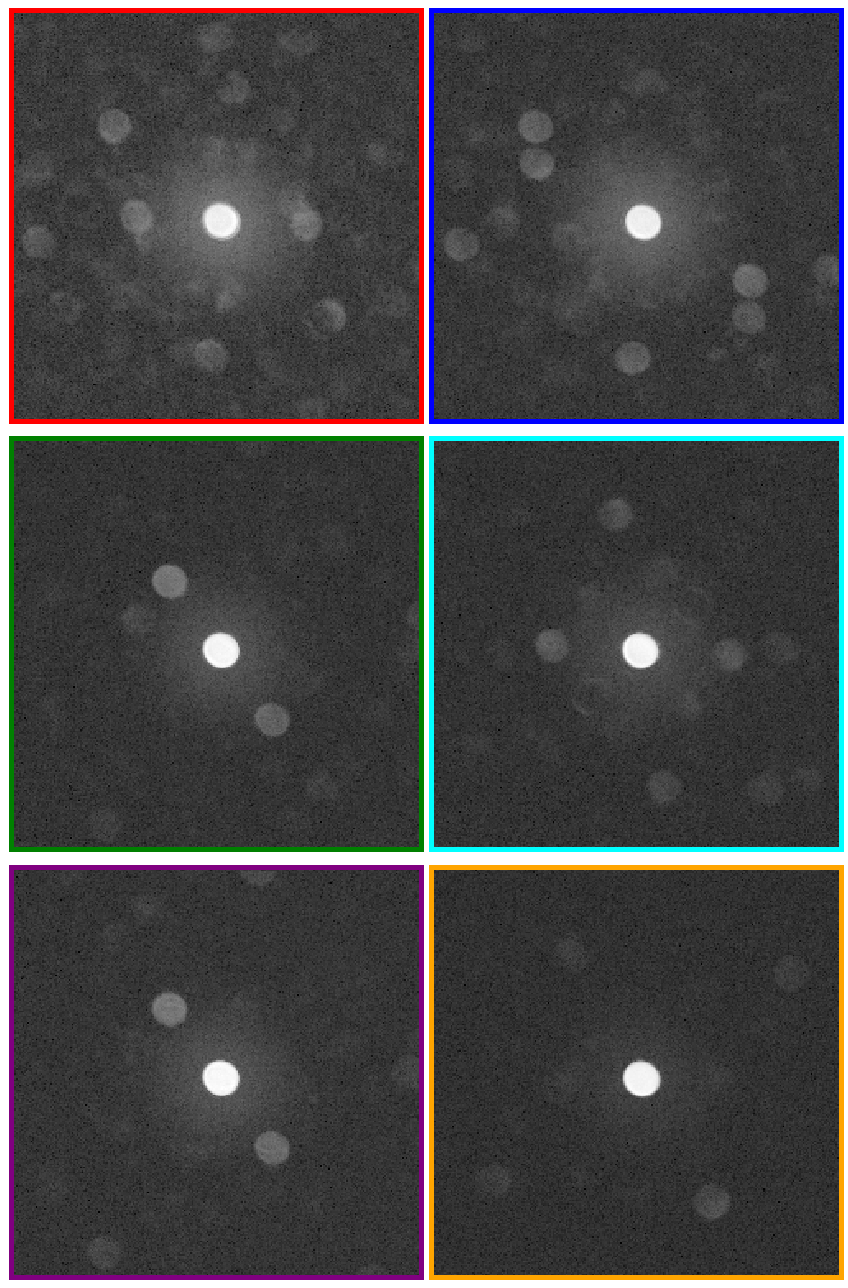

In [15]:
# Select scan positions for parameter testing

rxs = 0,3,5,10,5,8
rys = 8,5,13,12,14,3
colors = ['r','b','g','cyan','purple','orange']

py4DSTEM.visualize.show_points(
    adf,
    x=rxs,
    y=rys,
    pointcolor=colors,
    figsize=(8,8)
)
py4DSTEM.visualize.show_image_grid(
    get_ar=lambda i:datacube.data[rxs[i],rys[i],:,:],
    H=3,W=2,
    get_bordercolor=lambda i:colors[i],
    scaling='power',
    power=0.125
)

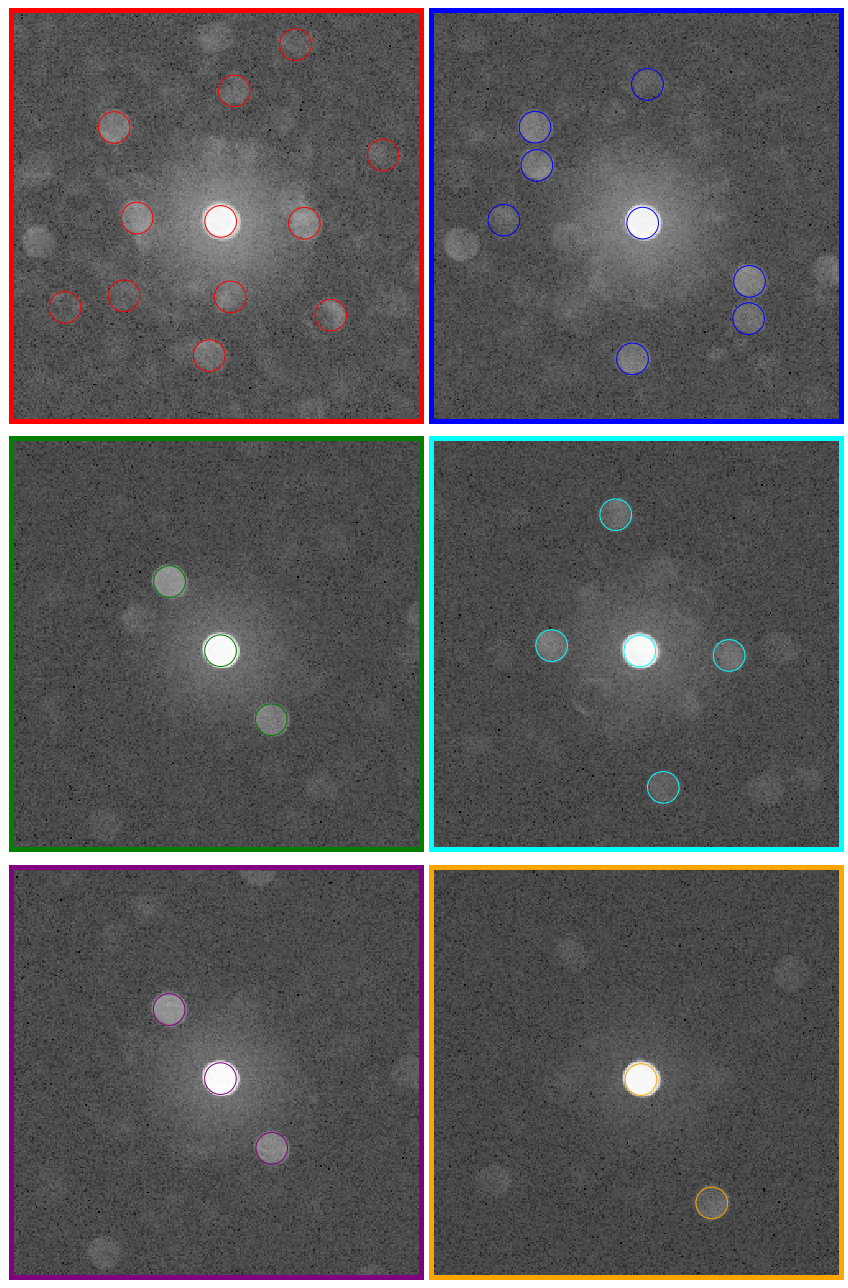

In [16]:
# Tune disk detection parameters on selected DPs
detect_params = {
    'minAbsoluteIntensity':0.05,
    'minPeakSpacing':20,
    'maxNumPeaks':30,
    'subpixel':'poly',
    'sigma':0,
    'edgeBoundary':20,
    'corrPower':1,
}

selected_peaks = datacube.find_Bragg_disks(
    data = (rxs,rys),
    template = probe.kernel,
    **detect_params
)

py4DSTEM.visualize.show_image_grid(
    get_ar=lambda i:datacube.data[rxs[i],rys[i],:,:],
    H=3,W=2,
    get_bordercolor=lambda i:colors[i],
    get_x=lambda i:selected_peaks[i].data['qx'],
    get_y=lambda i:selected_peaks[i].data['qy'],
    get_pointcolors=lambda i:colors[i],
    scaling='log',
    open_circles=True,
    scale=1000)

In [17]:
# Get all disks
braggvectors = datacube.find_Bragg_disks(
    template=probe.kernel,
    **detect_params
)

Finding Bragg Disks: 100%|██████████████████████████████████████████████████████| 8.40k/8.40k [01:07<00:00, 124DP/s]


## Get the Bragg vector map

In [18]:
bvm_uncal = braggvectors.get_bvm( mode='raw')

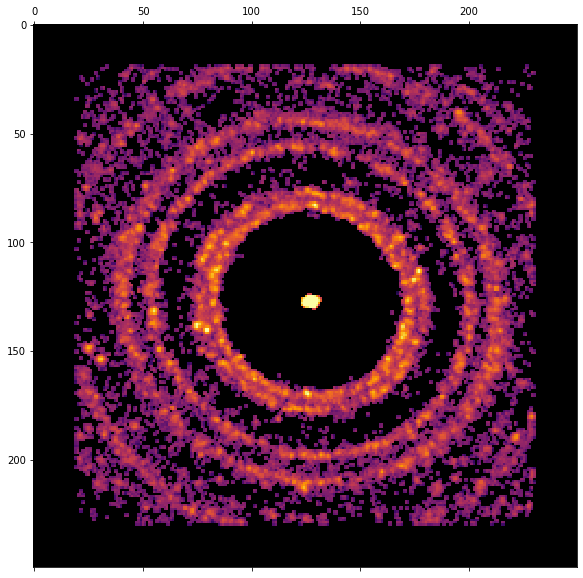

In [19]:
# Set visualization parameters

bvm_vis_params = {
    'cmap':'inferno',
    'scaling':'power',
    'power':0.125,
    'clipvals':'manual',
    'min':0,
    'max':5000    
}

py4DSTEM.visualize.show(
    bvm_uncal,
    **bvm_vis_params,
    figsize=(10,10)
)

## Find the origin

In [20]:
# Measure the origin position

origins_meas = braggvectors.measure_origin( mode='no_beamstop')

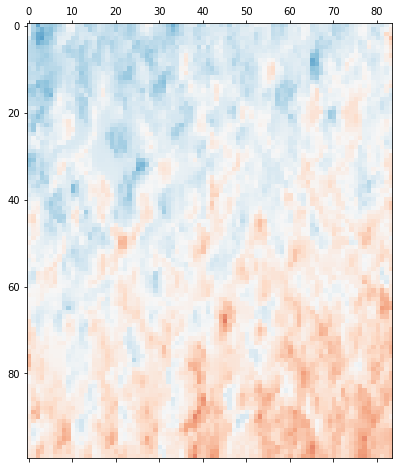

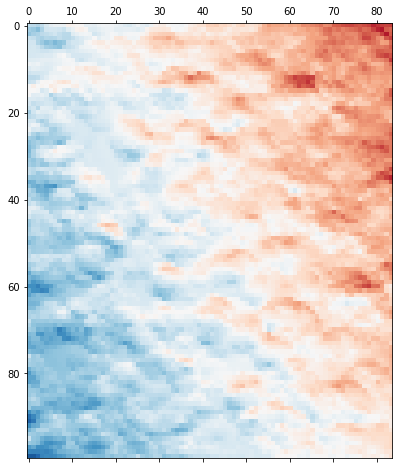

In [21]:
# Show the measured origins

qx0_meas,qy0_meas,mask = origins_meas[0],origins_meas[1],origins_meas[2]
py4DSTEM.visualize.show(
    qx0_meas,
    mask = mask,
    cmap='RdBu',
    clipvals='centered',
    min=np.mean(qx0_meas[mask]),
    max=5
)
py4DSTEM.visualize.show(
    qy0_meas,
    mask = mask,
    cmap='RdBu',
    clipvals='centered',
    min=np.mean(qy0_meas[mask]),
    max=5
)

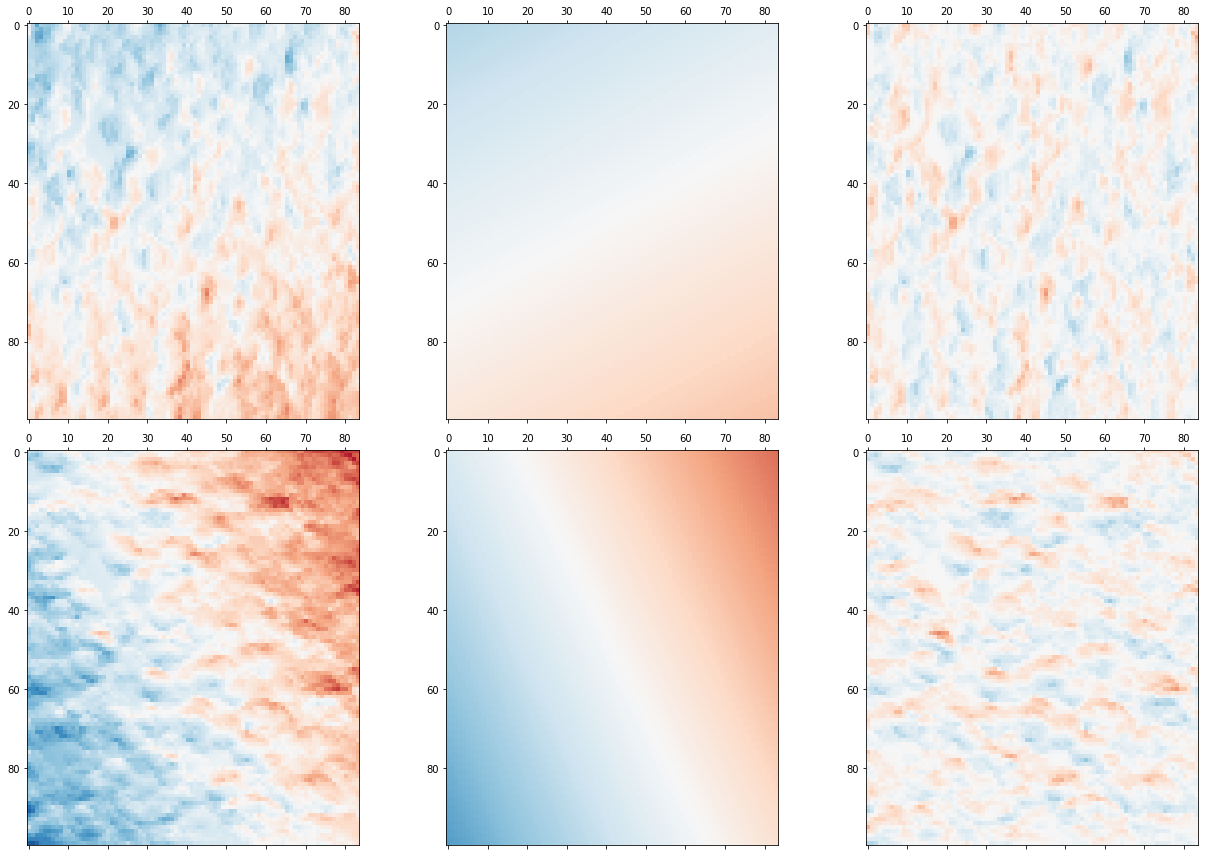

In [22]:
# Fit the origins

x = py4DSTEM.process.calibration.fit_origin(
    (qx0_meas,qy0_meas),
    fitfunction='plane')
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = x
ar = lambda i:[qx0_meas,qx0_fit,qx0_residuals,
               qy0_meas,qy0_fit,qy0_residuals][i]
im = lambda i: ar(i) - np.mean(ar(i)[mask])
py4DSTEM.visualize.show_image_grid(
    im,
    H=2,
    W=3,
    cmap='RdBu',
    clipvals='centered',
    min=0,
    max=5,
)

In [23]:
# Calibrate the origin

braggvectors.calibration.set_origin( (qx0_fit,qy0_fit) )

In [24]:
# Center the disk positions about the origin

braggvectors.calibrate()

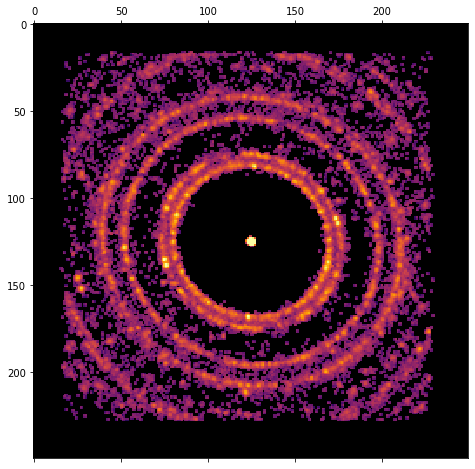

In [25]:
# Centered BVM

bvm_centered = braggvectors.get_bvm()
show(
   bvm_centered,
   **bvm_vis_params
)

## Elliptical distortion calibration

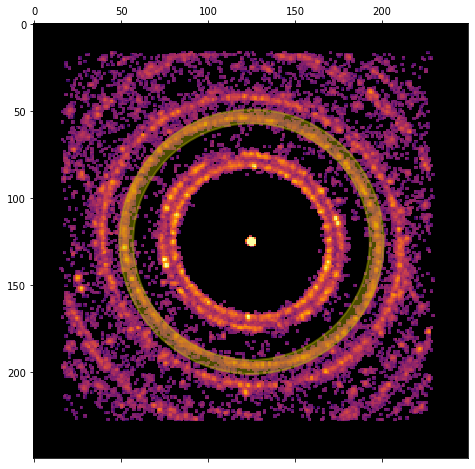

In [26]:
# Select fitting region

qmin,qmax = 68,76
py4DSTEM.visualize.show(
    bvm_centered,
    **bvm_vis_params,
    annulus={'center':(datacube.Q_Nx/2.,datacube.Q_Ny/2.),
             'radii':(qmin,qmax),
             'fill':True,
             'color':'y',
             'alpha':0.4})

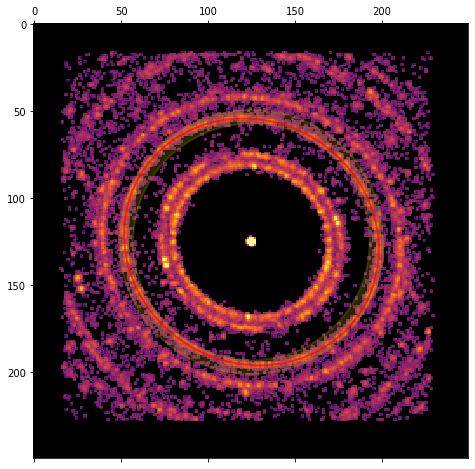

In [27]:
# Fit the elliptical distortions

p_ellipse = py4DSTEM.process.calibration.fit_ellipse_1D(
    bvm_centered,
    (datacube.Q_Nx/2.,datacube.Q_Ny/2.),
    (qmin,qmax)
)
py4DSTEM.visualize.show_elliptical_fit(
    bvm_centered,
    (qmin,qmax),
    p_ellipse,
    **bvm_vis_params
)

In [28]:
# Elliptical calibration

datacube.calibration.set_p_ellipse( p_ellipse )

In [29]:
# Elliptically correct bragg peak positions, stretching the elliptical
# semiminor axis to match the semimajor axis length

braggvectors.calibrate()

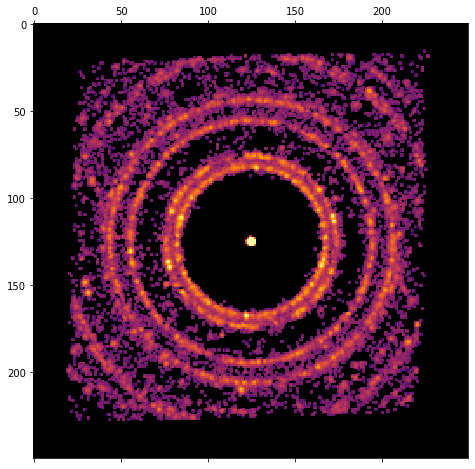

In [30]:
# Recompute the bvm

bvm_ellipsecorr = braggvectors.get_bvm()
show(bvm_ellipsecorr,**bvm_vis_params)

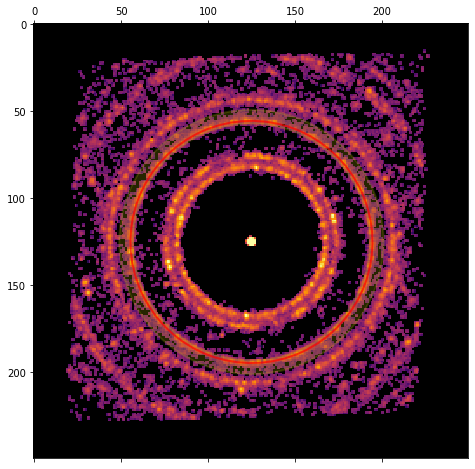

The ratio of the semimajor to semiminor axes was measured to be

	107.16% in the original data and
	100.11% in the corrected data.


In [31]:
# Confirm that elliptical distortions have been removed
# by measuring the ellipticity of the corrected data

p_ellipse_corr = py4DSTEM.process.calibration.fit_ellipse_1D(
    bvm_ellipsecorr,
    p_ellipse[:2],
    (qmin,qmax)
)
py4DSTEM.visualize.show_elliptical_fit(
   bvm_ellipsecorr,
   (qmin,qmax),
   p_ellipse_corr,
   **bvm_vis_params
)

#Print the ratio of the semi-axes before and after correction
print("The ratio of the semimajor to semiminor axes was measured to be")
print("")
print("\t{:.2f}% in the original data and".format(100*p_ellipse[2]/p_ellipse[3]))
print("\t{:.2f}% in the corrected data.".format(100*p_ellipse_corr[2]/p_ellipse_corr[3]))

## Pixel size calibration

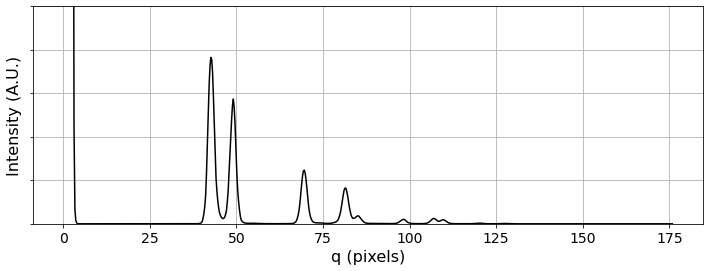

In [32]:
# # Radial integration
ymax = 100000
dq=0.25             # binsize for the x-axis

q,I_radial = py4DSTEM.process.utils.radial_integral(
    bvm_ellipsecorr,
    datacube.Q_Nx/2,
    datacube.Q_Ny/2,
    dr=dq
)
py4DSTEM.visualize.show_qprofile(q=q,intensity=I_radial,ymax=ymax)

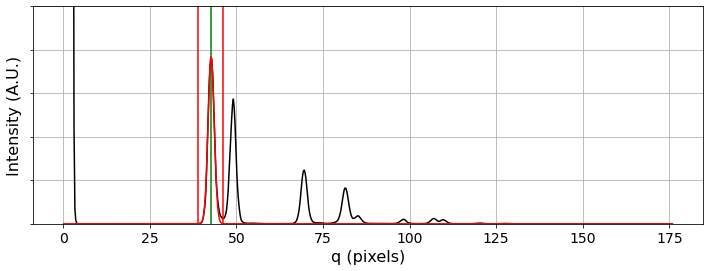

In [33]:
# Fit a gaussian to find a peak location

qmin,qmax = 39,46
A,mu,sigma = py4DSTEM.process.fit.fit_1D_gaussian(q,I_radial,qmin,qmax)

fig,ax = py4DSTEM.visualize.show_qprofile(q=q,intensity=I_radial,ymax=ymax,
                                          returnfig=True)
ax.vlines((qmin,qmax),0,ax.get_ylim()[1],color='r')
ax.vlines(mu,0,ax.get_ylim()[1],color='g')
ax.plot(q,py4DSTEM.process.fit.gaussian(q,A,mu,sigma),color='r')
plt.show()

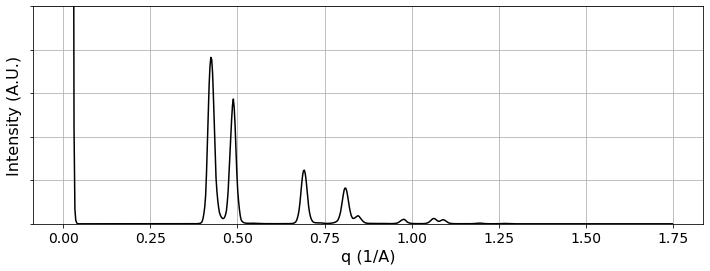

In [34]:
# Get pixel calibration
# At time of writing, one peak with a known spacing
# must be manually identified and entered

d_spacing_A = 2.355                           # This is the Au 111 peak
inv_A_per_pixel = 1./(d_spacing_A * mu)
py4DSTEM.visualize.show_qprofile(q=q*inv_A_per_pixel,intensity=I_radial,
                                 ymax=ymax,xlabel='q (1/A)')

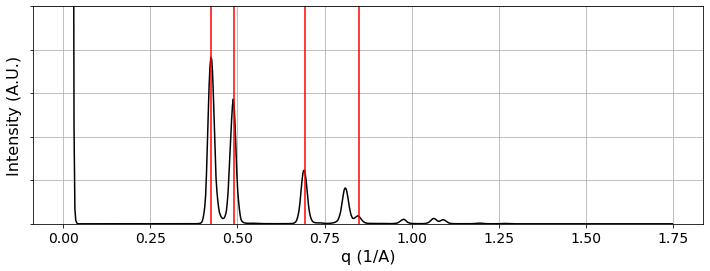

In [35]:
# Demonstrate consistency with known Al spacings
spacings_A = np.array([1.177,1.442,2.039,2.355])   # 222, 220, 200, 111
spacings_inv_A = 1./spacings_A

fig,ax = py4DSTEM.visualize.show_qprofile(q=q*inv_A_per_pixel,intensity=I_radial,
                                 ymax=ymax,xlabel='q (1/A)',returnfig=True)
ax.vlines(spacings_inv_A,0,ax.get_ylim()[1],color='r')
plt.show()

In [36]:
# Pixel calibration

datacube.calibration.set_Q_pixel_size(inv_A_per_pixel)
datacube.calibration.set_Q_pixel_units('A^-1')

In [37]:
# Calibrate bragg vector distances

braggvectors.calibrate()

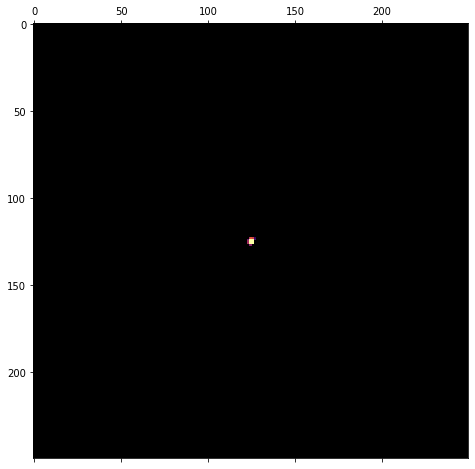

In [38]:
# Recompute the bvm

bvm_pixel = braggvectors.get_bvm()
show(bvm_pixel,**bvm_vis_params)

## Show calibrated data

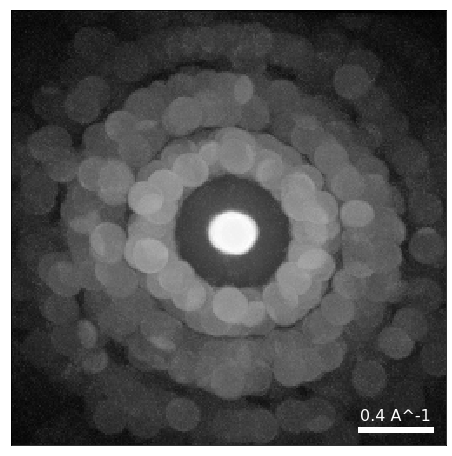

In [39]:
show(
    dp_max,
    scaling='log',
)

## Save

In [40]:
filepath_calibration_processing = "/media/AuxDriveB/Data/4DSTEM_SampleData/ColinOphus_CalibrationSimulations_StrainedAuNanoplatelet_20191112/data/calibration_processing.h5"

In [41]:
# save calibrations

py4DSTEM.io.save(
    filepath_calibration_processing,
    datacube,
    mode = 'o',
    tree = 'noroot'
)

100%|█████████████████████████████████████████████████████████████████████████| 8400/8400 [00:01<00:00, 6390.69it/s]


In [42]:
py4DSTEM.io.print_h5_tree(
    filepath_calibration_processing
)

/
|--4DSTEM
	|--circular_probe_polyAu
		|--adf
		|--bf
		|--braggvectors
		|	|--_v_cal
		|	|--_v_uncal
		|--calibration
		|--dp_max




## Read

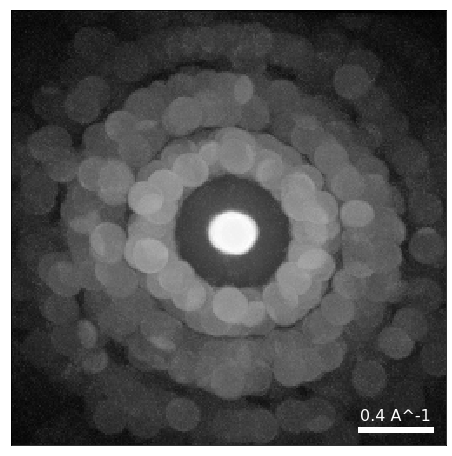

In [43]:
d = py4DSTEM.io.read(
   filepath_calibration_processing,
   root = '4DSTEM/circular_probe_polyAu/dp_max/',
)

show(d, scaling='log')

## Transfer calibrations

In [44]:
probe_test = py4DSTEM.io.DiffractionSlice(data=probe.probe)

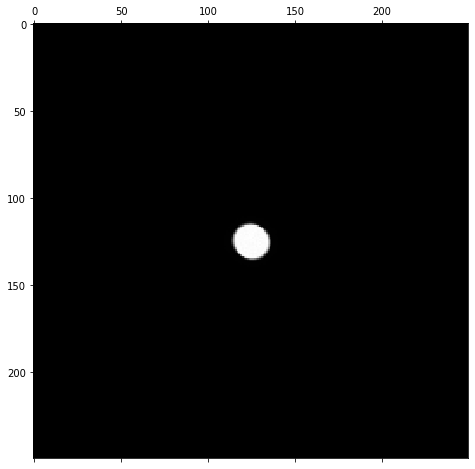

In [45]:
show(probe_test)

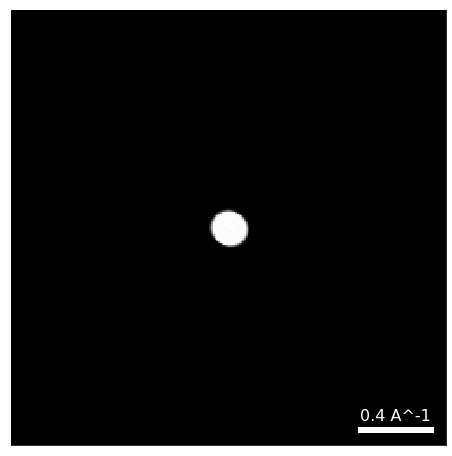

In [46]:
probe_test.calibration = datacube.calibration

show(probe_test)